In [1]:
import matplotlib.pyplot as plt

import torch
from torch.utils.data import Dataset, DataLoader

import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F

import torchvision
from torchvision import transforms


import cv2 as cv

import numpy as np

from glob import glob

from tqdm.notebook import tqdm

In [38]:
class SynthDataset(Dataset):
    def __init__(self):
        self.imgs_path = '/data/scratch/bariskurtkaya/synthetic_dataset/'
        self.data = []
        
        for img_path in glob(self.imgs_path + '/*.png'):
            if 'exo' in img_path:
                self.data.append([img_path, 'star_exo'])
            else:
                self.data.append([img_path, 'star_only'])
        
        print(self.data[0])
        self.class_map = {'star_only' : 0, 'star_exo': 1}
        self.img_dim = (28, 28)

    
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        train_transform = transforms.Compose([
            transforms.ToTensor(),
        ])
        
        img_path, class_name = self.data[idx]
        img = cv.imread(img_path, 0)
                
        #img = cv.resize(img, self.img_dim)
        class_id = self.class_map[class_name]
        img_tensor = torch.from_numpy(img)
        
        img_tensor = img_tensor.float()
        
        #img_tensor = img_tensor.permute(2, 0, 1)
        class_id = torch.tensor([class_id])
        return img_tensor, class_id


In [39]:
dataset = SynthDataset()
train_loader = DataLoader(dataset, batch_size=256, shuffle=True)

image = next(iter(train_loader))[0][0]

['/data/scratch/bariskurtkaya/synthetic_dataset/trial5263.png', 'star_only']


torch.Size([48, 64])


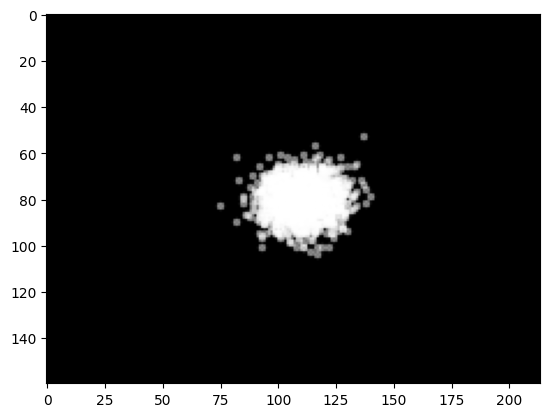

In [121]:
print(image.shape)

fig = plt.figure
plt.imshow(image, cmap='gray')
plt.show()

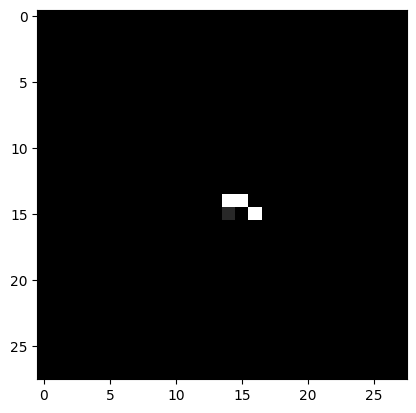

In [63]:
img = cv.imread('trial_exo.png', 0)

fig = plt.figure
plt.imshow(img, cmap='gray')
plt.show()

In [64]:
def set_device():
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    if device.type == 'cuda':
        print('Total GPU count:', torch.cuda.device_count())
        print('Selected GPU index:', torch.cuda.current_device())
        current_device = torch.cuda.current_device()
        print('Selected GPU Name:', torch.cuda.get_device_name(current_device))
        print('Memory Usage:')
        print('Allocated:', round(torch.cuda.memory_allocated(current_device)/1024**3,1), 'GB')
        print('Cached:   ', round(torch.cuda.memory_reserved(current_device)/1024**3,1), 'GB')
        print('Max Memmory Cached:', round(torch.cuda.max_memory_cached(current_device)/1024**3,1), 'GB')
    
    return device

In [65]:
class Encoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        
        ### Convolutional section
        self.encoder_cnn = nn.Sequential(
            nn.Conv2d(1, 8, 3, stride=2, padding=1),
            nn.ReLU(True),
            nn.Conv2d(8, 16, 3, stride=2, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.Conv2d(16, 32, 3, stride=2, padding=0),
            nn.ReLU(True)
        )
        
        ### Flatten layer
        self.flatten = nn.Flatten(start_dim=1)
        ### Linear section
        self.encoder_lin = nn.Sequential(
            nn.Linear(3 * 3 * 32, 128),
            nn.ReLU(True),
            nn.Linear(128, encoded_space_dim)
        )
        
    def forward(self, x):
        x = torch.unsqueeze(x,1)
        x = self.encoder_cnn(x)
        x = self.flatten(x)
        x = self.encoder_lin(x)
        return x
    

In [66]:
class Decoder(nn.Module):
    
    def __init__(self, encoded_space_dim,fc2_input_dim):
        super().__init__()
        self.decoder_lin = nn.Sequential(
            nn.Linear(encoded_space_dim, 128),
            nn.ReLU(True),
            nn.Linear(128, 3 * 3 * 32),
            nn.ReLU(True)
        )

        self.unflatten = nn.Unflatten(dim=1, 
        unflattened_size=(32, 3, 3))

        self.decoder_conv = nn.Sequential(
            nn.ConvTranspose2d(32, 16, 3, 
            stride=2, output_padding=0),
            nn.BatchNorm2d(16),
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 3, stride=2, 
            padding=1, output_padding=1),
            nn.BatchNorm2d(8),
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 3, stride=2, 
            padding=1, output_padding=1)
        )
        
    def forward(self, x):
        x = self.decoder_lin(x)
        x = self.unflatten(x)
        x = self.decoder_conv(x)
        x = torch.sigmoid(x)
        return x

In [67]:
device = set_device()

### Define the loss function
loss_fn = torch.nn.MSELoss()

### Define an optimizer (both for the encoder and the decoder!)
lr= 0.001

### Set the random seed for reproducible results
torch.manual_seed(0)

### Initialize the two networks
d = 4

#model = Autoencoder(encoded_space_dim=encoded_space_dim)
encoder = Encoder(encoded_space_dim=d,fc2_input_dim=128)
decoder = Decoder(encoded_space_dim=d,fc2_input_dim=128)
params_to_optimize = [
    {'params': encoder.parameters()},
    {'params': decoder.parameters()}
]

optim = torch.optim.Adam(params_to_optimize, lr=lr, weight_decay=1e-05)

# Check if the GPU is available
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Selected device: {device}')

# Move both the encoder and the decoder to the selected device
encoder.to(device)
decoder.to(device)


Total GPU count: 4
Selected GPU index: 0
Selected GPU Name: NVIDIA RTX A6000
Memory Usage:
Allocated: 0.2 GB
Cached:    0.6 GB
Max Memmory Cached: 0.6 GB
Selected device: cuda


/home/bariskurtkaya/miniconda3/envs/jwst/lib/python3.10/site-packages/torch/cuda/memory.py:403: FutureWarning: torch.cuda.max_memory_cached has been renamed to torch.cuda.max_memory_reserved
  warnings.warn(


Decoder(
  (decoder_lin): Sequential(
    (0): Linear(in_features=4, out_features=128, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=128, out_features=288, bias=True)
    (3): ReLU(inplace=True)
  )
  (unflatten): Unflatten(dim=1, unflattened_size=(32, 3, 3))
  (decoder_conv): Sequential(
    (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): ConvTranspose2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
    (4): BatchNorm2d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): ConvTranspose2d(8, 1, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
  )
)

In [68]:
### Training function
def train_epoch(encoder, decoder, device, dataloader, loss_fn, optimizer):
    # Set train mode for both the encoder and the decoder
    encoder.train()
    decoder.train()
    train_loss = []
    # Iterate the dataloader (we do not need the label values, this is unsupervised learning)
    for image_batch, _ in dataloader: # with "_" we just ignore the labels (the second element of the dataloader tuple)
        # Move tensor to the proper device
        image_batch = image_batch.to(device)
        # Encode data
        encoded_data = encoder(image_batch)
        # Decode data
        decoded_data = decoder(encoded_data)
        # Evaluate loss
        loss = loss_fn(decoded_data, image_batch)
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Print batch loss
        print('\t partial train loss (single batch): %f' % (loss.data))
        train_loss.append(loss.detach().cpu().numpy())

    return np.mean(train_loss)

In [69]:
### Testing function
def test_epoch(encoder, decoder, device, dataloader, loss_fn):
    # Set evaluation mode for encoder and decoder
    encoder.eval()
    decoder.eval()
    with torch.no_grad(): # No need to track the gradients
        # Define the lists to store the outputs for each batch
        conc_out = []
        conc_label = []
        for image_batch, _ in dataloader:
            # Move tensor to the proper device
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            decoded_data = decoder(encoded_data)
            # Append the network output and the original image to the lists
            conc_out.append(decoded_data.cpu())
            conc_label.append(image_batch.cpu())
        # Create a single tensor with all the values in the lists
        conc_out = torch.cat(conc_out)
        conc_label = torch.cat(conc_label) 
        # Evaluate global loss
        val_loss = loss_fn(conc_out, conc_label)
    return val_loss.data

In [70]:
num_epochs = 300
diz_loss = {'train_loss':[]}
for epoch in range(num_epochs):
    train_loss = train_epoch(encoder,decoder,device,train_loader,loss_fn,optim)
    
    #print('\n EPOCH {}/{} \t train loss {} '.format(epoch + 1, num_epochs,train_loss))
    
    diz_loss['train_loss'].append(train_loss)
    #plot_ae_outputs(encoder,decoder,n=10)

	 partial train loss (single batch): 880.617737
	 partial train loss (single batch): 895.228943
	 partial train loss (single batch): 975.707947
	 partial train loss (single batch): 838.801025
	 partial train loss (single batch): 944.894104
	 partial train loss (single batch): 978.797791
	 partial train loss (single batch): 911.300232
	 partial train loss (single batch): 921.001343
	 partial train loss (single batch): 872.389893
	 partial train loss (single batch): 945.659912
	 partial train loss (single batch): 989.527832
	 partial train loss (single batch): 998.719910
	 partial train loss (single batch): 910.443359
	 partial train loss (single batch): 922.828369
	 partial train loss (single batch): 966.869385
	 partial train loss (single batch): 986.621399
	 partial train loss (single batch): 877.008423
	 partial train loss (single batch): 891.335388
	 partial train loss (single batch): 982.620056
	 partial train loss (single batch): 938.578918
	 partial train loss (single batch): 903

/home/bariskurtkaya/miniconda3/envs/jwst/lib/python3.10/site-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([211, 28, 28])) that is different to the input size (torch.Size([211, 1, 28, 28])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


	 partial train loss (single batch): 899.819153
	 partial train loss (single batch): 944.883606
	 partial train loss (single batch): 962.743103
	 partial train loss (single batch): 944.643555
	 partial train loss (single batch): 1021.593750
	 partial train loss (single batch): 957.534119
	 partial train loss (single batch): 997.211548
	 partial train loss (single batch): 924.782898
	 partial train loss (single batch): 920.366699
	 partial train loss (single batch): 1122.348999
	 partial train loss (single batch): 738.920349
	 partial train loss (single batch): 856.666260
	 partial train loss (single batch): 980.498718
	 partial train loss (single batch): 863.078247
	 partial train loss (single batch): 969.891235
	 partial train loss (single batch): 890.042725
	 partial train loss (single batch): 880.013367
	 partial train loss (single batch): 883.836060
	 partial train loss (single batch): 894.786560
	 partial train loss (single batch): 896.673706
	 partial train loss (single batch): 8

In [71]:
def plot_ae_outputs(encoder,decoder,n=10):
    plt.figure(figsize=(16,4.5))
    
    encoder.eval()
    decoder.eval()
    with torch.no_grad():
        for image_batch, labels in train_loader:
            image_batch = image_batch.to(device)
            # Encode data
            encoded_data = encoder(image_batch)
            # Decode data
            rec_img = decoder(encoded_data)
        
        for i in range(n):
            ax = plt.subplot(2,n,i+1)
            plt.imshow(image_batch[i].cpu().squeeze().numpy(), cmap='gist_gray')
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == n//2:
                ax.set_title('Original images')
            ax = plt.subplot(2, n, i + 1 + n)
            plt.imshow(rec_img[i].cpu().squeeze().numpy(), cmap='gist_gray')  
            ax.get_xaxis().set_visible(False)
            ax.get_yaxis().set_visible(False)  
            if i == n//2:
                ax.set_title('Reconstructed images')
    plt.show()   

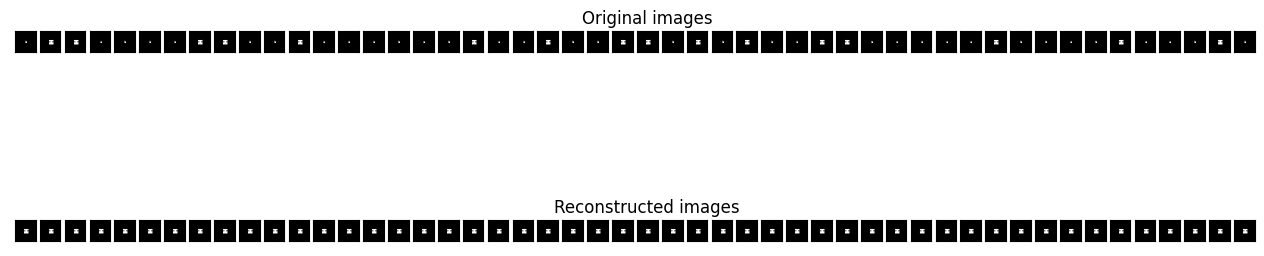

In [73]:
plot_ae_outputs(encoder, decoder, 50)

In [74]:
model_weights = [] 
conv_layers = [] 
model_children = list(encoder.children())

# counter to keep count of the conv layers
counter = 0 
# append all the conv layers and their respective weights to the list
for i in range(len(model_children)):
    if type(model_children[i]) == nn.Conv2d:
        counter += 1
        model_weights.append(model_children[i].weight)
        conv_layers.append(model_children[i])
    elif type(model_children[i]) == nn.Sequential:
        for j in range(len(model_children[i])):
            for child in model_children[i][j].children():
                if type(child) == nn.Conv2d:
                    counter += 1
                    model_weights.append(child.weight)
                    conv_layers.append(child)
print(f"Total convolutional layers: {counter}")

Total convolutional layers: 0


In [75]:
for weight, conv in zip(model_weights, conv_layers):
    # print(f"WEIGHT: {weight} \nSHAPE: {weight.shape}")
    print(f"CONV: {conv} ====> SHAPE: {weight.shape}")

In [76]:
# visualize the first conv layer filters
plt.figure(figsize=(20, 17))
for i, filter in enumerate(model_weights[0]):
    plt.subplot(4, 4, i+1) # we have 5x5 filters and total of 16 (see printed shapes)
    plt.imshow(filter[0, :, :].detach().cpu().numpy(), cmap='viridis')
    plt.axis('off')
    #plt.savefig('filter1.png')
plt.show()

IndexError: list index out of range

<Figure size 2000x1700 with 0 Axes>